In [2]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from sklearn.linear_model import LinearRegression, Lasso, Ridge
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import scipy.stats as stats

In [3]:
df_orig = pd.read_csv('MotoGP_2002_2018.csv', index_col=0, parse_dates=['Date'])

In [4]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24141 entries, 0 to 24140
Data columns (total 29 columns):
Year                          24141 non-null int64
TRK                           24141 non-null object
Track                         24141 non-null object
Category                      24141 non-null object
Session                       24141 non-null object
Date                          24136 non-null datetime64[ns]
Track_Condition               20883 non-null object
Track_Temp                    20883 non-null float64
Air_Temp                      20883 non-null float64
Humidity                      20883 non-null float64
Position                      24136 non-null object
Points                        24136 non-null float64
Rider_Number                  20883 non-null float64
Rider_Name                    24136 non-null object
Nationality                   24136 non-null object
Team_Name                     20883 non-null object
Bike                          24136 non-null ob

In [5]:
df = df_orig.copy(deep=True)

In [6]:
# convert finish time into a numerical since it'll be the target of our regression
df['Finish_Time'] = df['Finish_Time'].map(lambda x: pd.to_timedelta(x))
df['Finish_Time_ms'] = df['Finish_Time'].map(lambda x: x/pd.to_timedelta(1, unit='ms'))

# add up left and right corners
df['corners'] = df['Left_Corners'] + df['Right_Corners']

# drop N/A values
df.dropna(axis = 0, inplace=True)

In [7]:

# examine the top 20 riders
(df
 .groupby(['Rider_Name'])['Points']
 .mean().reset_index()
 .sort_values(by='Points', ascending=False)
).head(20)

,Rider_Name,Points
66,Can ONCU,25.000000
86,Daniel PEDROSA,22.555556
282,Marc MARQUEZ,19.358974
69,Casey STONER,17.742857
206,Jorge LORENZO,17.375000
439,Valentino ROSSI,16.077419
82,Dani PEDROSA,15.985507
300,Maverick VIÑALES,13.833333
23,Alex RINS,13.500000
191,Joan MIR,13.472222


In [8]:
df.replace(to_replace='Daniel PEDROSA', value='Dani PEDROSA', inplace=True)
df_rider_mean = (df
                 .groupby(['Rider_Name'])['Points']
                 .mean().reset_index()
                 .sort_values(by='Points', ascending=False)
                )
df_rider_mean.rename(columns={'Points':'points_mean'}, inplace=True)
df_rider_mean.head(20)

,Rider_Name,points_mean
66,Can ONCU,25.000000
281,Marc MARQUEZ,19.358974
69,Casey STONER,17.742857
205,Jorge LORENZO,17.375000
82,Dani PEDROSA,16.387755
438,Valentino ROSSI,16.077419
299,Maverick VIÑALES,13.833333
23,Alex RINS,13.500000
190,Joan MIR,13.472222
33,Andrea DOVIZIOSO,13.006623


In [9]:
df.groupby('Rider_Name').count()

,Year,TRK,Track,Category,Session,Date,Track_Condition,Track_Temp,Air_Temp,Humidity,...,Left_Corners,Right_Corners,track_width,length of longest straight,MotoGP_avg_speed,GP_distance,Moto2_distance,Moto3_distance,Finish_Time_ms,corners
Rider_Name,,,,,,,,,,,,,,,,,,,,,
Aaron POLANCO,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Adam NORRODIN,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
Adrian MARTIN,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
Ai OGURA,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Aitor RODRIGUEZ,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Alan TECHER,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
Albert ARENAS,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
Alberto MONCAYO,43,43,43,43,43,43,43,43,43,43,...,43,43,43,43,43,43,43,43,43,43
Aleix ESPARGARO,124,124,124,124,124,124,124,124,124,124,...,124,124,124,124,124,124,124,124,124,124


In [10]:
threshold = 2000000
df[(df.Finish_Time_ms <= threshold)].sample(5)

,Year,TRK,Track,Category,Session,Date,Track_Condition,Track_Temp,Air_Temp,Humidity,...,Left_Corners,Right_Corners,track_width,length of longest straight,MotoGP_avg_speed,GP_distance,Moto2_distance,Moto3_distance,Finish_Time_ms,corners
2826,2017,JPN,JPN - Twin Ring Motegi,Moto2,RAC,2017-10-15,Wet,15.0,14.0,97.0,...,6.0,8.0,15.0,762.0,162.2,115.2,105.6,96.0,1940473.0,14.0
8232,2013,SPA,SPA - Circuito de Jerez,Moto3,RAC,2013-05-05,Dry,33.0,23.0,43.0,...,6.0,8.0,11.0,607.0,161.2,110.6,101.7,97.3,1632442.0,14.0
2839,2017,JPN,JPN - Twin Ring Motegi,Moto2,RAC,2017-10-15,Wet,15.0,14.0,97.0,...,6.0,8.0,15.0,762.0,162.2,115.2,105.6,96.0,1975714.0,14.0
12665,2010,SPA,SPA - Circuito de Jerez,Moto2,RAC,2010-05-02,Dry,41.0,26.0,31.0,...,6.0,8.0,11.0,607.0,161.2,110.6,101.7,97.3,1802551.0,14.0
2359,2017,CZE,CZE - Automotodrom Brno,Moto2,RAC,2017-08-06,Dry,22.0,20.0,80.0,...,6.0,8.0,15.0,636.0,165.5,113.5,102.7,97.3,881564.0,14.0


In [11]:
df = df[df.Category == "MotoGP"]
df

,Year,TRK,Track,Category,Session,Date,Track_Condition,Track_Temp,Air_Temp,Humidity,...,Left_Corners,Right_Corners,track_width,length of longest straight,MotoGP_avg_speed,GP_distance,Moto2_distance,Moto3_distance,Finish_Time_ms,corners
0,2018,QAT,QAT - Losail International Circuit,MotoGP,RAC,2018-03-18,Dry,23.0,21.0,46.0,...,6.0,10.0,12.0,1068.0,166.6,118.4,107.6,96.8,2554654.0,16.0
1,2018,QAT,QAT - Losail International Circuit,MotoGP,RAC,2018-03-18,Dry,23.0,21.0,46.0,...,6.0,10.0,12.0,1068.0,166.6,118.4,107.6,96.8,2554681.0,16.0
2,2018,QAT,QAT - Losail International Circuit,MotoGP,RAC,2018-03-18,Dry,23.0,21.0,46.0,...,6.0,10.0,12.0,1068.0,166.6,118.4,107.6,96.8,2555451.0,16.0
3,2018,QAT,QAT - Losail International Circuit,MotoGP,RAC,2018-03-18,Dry,23.0,21.0,46.0,...,6.0,10.0,12.0,1068.0,166.6,118.4,107.6,96.8,2557535.0,16.0
4,2018,QAT,QAT - Losail International Circuit,MotoGP,RAC,2018-03-18,Dry,23.0,21.0,46.0,...,6.0,10.0,12.0,1068.0,166.6,118.4,107.6,96.8,2558475.0,16.0
5,2018,QAT,QAT - Losail International Circuit,MotoGP,RAC,2018-03-18,Dry,23.0,21.0,46.0,...,6.0,10.0,12.0,1068.0,166.6,118.4,107.6,96.8,2558542.0,16.0
6,2018,QAT,QAT - Losail International Circuit,MotoGP,RAC,2018-03-18,Dry,23.0,21.0,46.0,...,6.0,10.0,12.0,1068.0,166.6,118.4,107.6,96.8,2559275.0,16.0
7,2018,QAT,QAT - Losail International Circuit,MotoGP,RAC,2018-03-18,Dry,23.0,21.0,46.0,...,6.0,10.0,12.0,1068.0,166.6,118.4,107.6,96.8,2561766.0,16.0
8,2018,QAT,QAT - Losail International Circuit,MotoGP,RAC,2018-03-18,Dry,23.0,21.0,46.0,...,6.0,10.0,12.0,1068.0,166.6,118.4,107.6,96.8,2567611.0,16.0
9,2018,QAT,QAT - Losail International Circuit,MotoGP,RAC,2018-03-18,Dry,23.0,21.0,46.0,...,6.0,10.0,12.0,1068.0,166.6,118.4,107.6,96.8,2569248.0,16.0


In [12]:
df_c = df.drop(axis=1, columns=['TRK', 'Track', 'Session', 'Date', 'Position', 'Rider_Name',
                                'Rider_Number', 'Nationality', 'Team_Name', 'Time', 'Finish_Time',
                                'Category', 'Left_Corners', 'Right_Corners', 'Bike', 'Avg_Speed'])

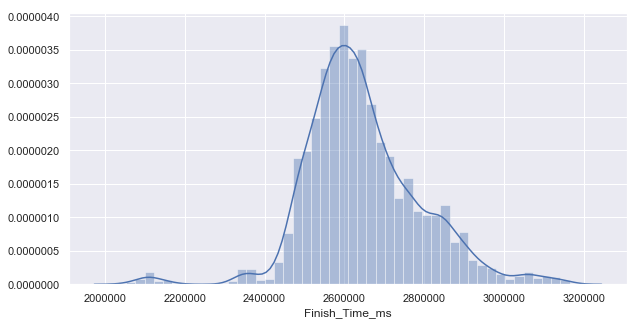

In [13]:
df_c_normal = df_c[df_c.Finish_Time_ms >= threshold]
plt.figure(figsize=(10,5))
sns.distplot(df_c_normal.Finish_Time_ms);

In [14]:
df_rider_mean = (df
                 .groupby(['Rider_Name'])['Points']
                 .mean().reset_index()
                 .sort_values(by='Points', ascending=False)
                )
df_rider_mean.rename(columns={'Points':'points_mean'}, inplace=True)
df_rider_mean.head(20)

,Rider_Name,points_mean
55,Marc MARQUEZ,20.052632
15,Casey STONER,17.901639
39,Jorge LORENZO,16.923729
91,Valentino ROSSI,16.077419
20,Dani PEDROSA,15.985507
6,Andrea DOVIZIOSO,12.598361
4,Alex RINS,11.647059
78,Sete GIBERNAU,11.250000
60,Max BIAGGI,11.222222
90,Troy BAYLISS,10.800000


In [15]:
df.columns

# ['Year', 'Track_Temp', 'Air_Temp', 'Humidity', 'Points',
#        'track_length_km', 'width_m', 'straight_m', 'GP_avg_speed', 'gp_dist',
#        'm2_dist', 'm3_dist', 'Finish_Time_ms', 'corners', 'points_mean',
#        'Category_125cc', 'Category_250cc', 'Category_Moto2', 'Category_Moto3',
#        'Category_MotoGP', 'Track_Condition_Dry', 'Track_Condition_Wet',
#        'Track_Condition_Wet-Dry'

Index(['Year', 'TRK', 'Track', 'Category', 'Session', 'Date',
       'Track_Condition', 'Track_Temp', 'Air_Temp', 'Humidity', 'Position',
       'Points', 'Rider_Number', 'Rider_Name', 'Nationality', 'Team_Name',
       'Bike', 'Avg_Speed', 'Time', 'Finish_Time', 'Trk Length',
       'Left_Corners', 'Right_Corners', 'track_width',
       'length of longest straight', 'MotoGP_avg_speed', 'GP_distance',
       'Moto2_distance', 'Moto3_distance', 'Finish_Time_ms', 'corners'],
      dtype='object')

In [17]:
df_merged = df.merge(df_rider_mean)
df_model_prepped = df_merged[["Rider_Name","points_mean", "Finish_Time_ms", "Track_Condition", "Track_Temp", "Humidity", "Avg_Speed", "Position","Trk Length","Moto3_distance", "Moto2_distance",]]
df_model_prepped.to_csv("model_prepped_data.csv")